In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn import metrics

from diffusion_functions import *
from semi_supervised_manifold_learning import *

# commands for displaying animations in jupyter notebook
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

# Instance illustration

In [2]:
def plot_label_comparison_binary(ax, label_vector, data_matrix, titlestring=None):
    error, threshold = find_min_sweepcut(label_vector,100,sweep_cut_classification_error)
    label_estimates = make_sweep_cut(label_vector, threshold)
    error = sweep_cut_classification_error(label_estimates)
    im = ax.scatter(data_matrix[:,0],data_matrix[:,1], c=label_estimates.reshape(-1))
    
    # figure formatting
    ax.set_aspect('equal')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axis('off')
    if titlestring=='Abridged':
        ax.set_title(f'Classification error = {error:.3f}', fontsize = 15)
    else:
        ax.set_title(titlestring +f'\n Classification error = {error:.3f}', fontsize = 15)
    return

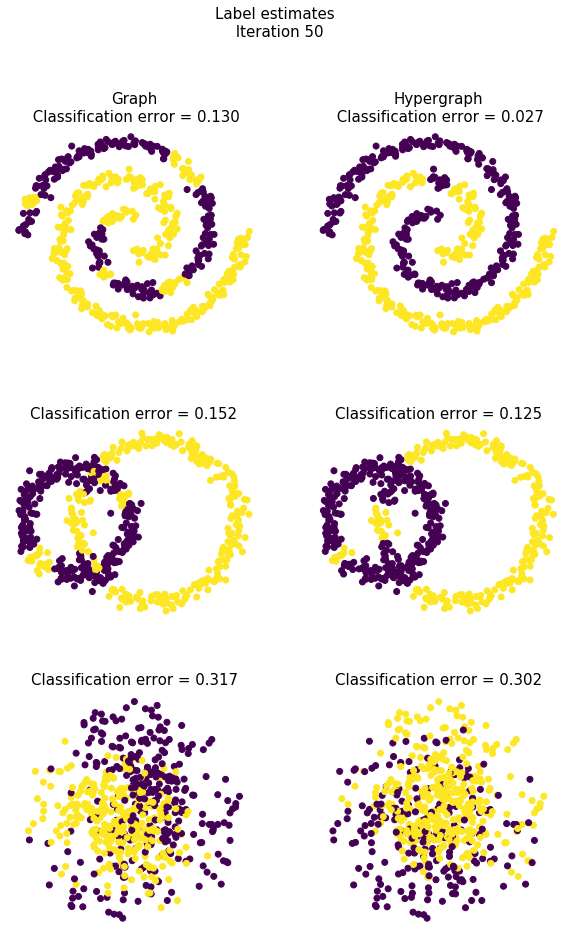

In [3]:
k = 5
target_iternum = 50
titlestring = 'blah'

fig_binary, ax_binary = plt.subplots(nrows=3, ncols=2,figsize=(10, 15))
problem_index = 0
for data_generation, problem_kind in [(generate_spirals,' Spirals'), (generate_overlapping_rings,' Rings'),
                                      (generate_concentric_highdim,' Concentric Highdim')]:
    
    graph_x, hypergraph_x, data_matrix = compare_estimated_labels(data_generation,k,target_iternum,titlestring=None, diffusion_step_size=1)

    for idx,(x,titlestring) in enumerate([(graph_x[-1],'Graph'), (hypergraph_x[-1],'Hypergraph')]):
        if problem_index==0:
            plot_label_comparison_binary(ax_binary[problem_index, idx],x, data_matrix,titlestring)
        else:
            plot_label_comparison_binary(ax_binary[problem_index, idx],x, data_matrix,titlestring = 'Abridged')
    problem_index+=1
    
plt.suptitle(f'Label estimates \n Iteration {target_iternum}', fontsize = 15)    
plt.show()

# AUC Histogram

In [4]:
def final_plot_AUC_hist(AUC_vals, ax, decorated = False):
    plt.rcParams.update({'font.size': 15})
        
    hypergraph_vals = [v[0] for v in AUC_vals]
    graph_vals = [v[1] for v in AUC_vals]
    
    full_values = hypergraph_vals+graph_vals
    _, first_bins = np.histogram(full_values, bins = 10)

    # second style
    ax.hist(graph_vals, bins = first_bins, alpha=0.5, edgecolor = 'black', label = 'graph')
    ax.hist(hypergraph_vals, bins = first_bins, alpha=0.5, edgecolor = 'black', label='hypergraph')
    
    if decorated:
        ax.set_title(f'AUC Values at Iteration 50 \n Results from 50 Independent Trials')
        ax.legend()
        
    # figure formatting
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    return

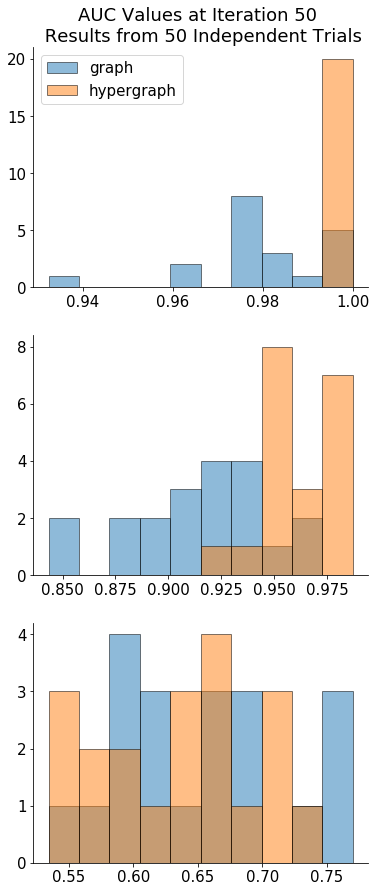

In [5]:
k = 5
iterations_to_plot = [50]
num_trials = 20

fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (6, 15))
axes_idx = 0

for data_generation, problem_kind in [(generate_spirals,'Spirals'), (generate_overlapping_rings,'Rings'),
                                      (generate_concentric_highdim,'Concentric hyperspheres')]:
    AUC_vals = []
    for trial in range(num_trials):
        # generate new data
        _,data_matrix = data_generation(verbose=False)

        # build graph/hypergraph
        knn_adj_matrix = build_knn_graph(data_matrix,k)
        knn_hgraph_dict = build_knn_hypergraph(data_matrix,k)

        # run diffusion
        max_iterations_needed = max(iterations_to_plot)
        hypergraph_diff_results, graph_diff_results = semi_superivsed_knn_clustering(knn_adj_matrix,
                        knn_hgraph_dict, num_iterations = max_iterations_needed, verbose = False)

        hypergraph_x = hypergraph_diff_results['x']
        graph_x = graph_diff_results['x']

        n = data_matrix.shape[0]
        labels = np.hstack([np.full(shape=int(n/2),fill_value = -1),np.full(shape=int(n/2),fill_value = 1)])
        graph_auc_score = metrics.roc_auc_score(labels, graph_x[-1, :])
        hypergraph_auc_score = metrics.roc_auc_score(labels, hypergraph_x[-1, :])

        AUC_vals.append((hypergraph_auc_score, graph_auc_score))
    final_plot_AUC_hist(AUC_vals, ax = ax[axes_idx], decorated = (axes_idx == 0) )
    axes_idx+=1
plt.show()
    